## Самостоятельная реализация свертки

In [1]:
import torch
from torch import nn

In [2]:
BATCH_SIZE = 256

In [3]:
import torchvision as tv
import time
import matplotlib.pyplot as plt

In [4]:
train_dataset = tv.datasets.FashionMNIST('~/MLDS/',
                                  train=True,
                                  transform=tv.transforms.ToTensor(),
                                  download=False)

test_dataset = tv.datasets.FashionMNIST('~/MLDS/',
                                 train=False,
                                 transform=tv.transforms.ToTensor(),
                                 download=False)

train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [5]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

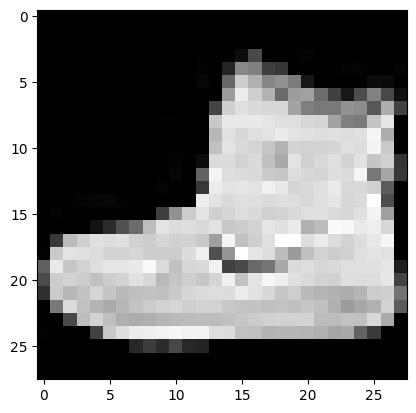

In [6]:
plt.imshow(train_dataset[0][0].numpy().reshape(28,28), cmap='gray');

In [7]:
print(train_dataset[0][1])

9


In [26]:
model = nn.Sequential(
    nn.Conv2d(1, 256, kernel_size=3, padding=1),
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(256, 128, kernel_size=5),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(128, 64, kernel_size=5),
    nn.Flatten(),
    nn.Dropout(0.1),
    nn.Linear(64, 10)
)

In [27]:
from torchsummary import summary

summary(model, input_size=(1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 256, 28, 28]           2,560
       BatchNorm2d-2          [-1, 256, 28, 28]             512
              ReLU-3          [-1, 256, 28, 28]               0
         MaxPool2d-4          [-1, 256, 14, 14]               0
            Conv2d-5          [-1, 128, 10, 10]         819,328
       BatchNorm2d-6          [-1, 128, 10, 10]             256
              ReLU-7          [-1, 128, 10, 10]               0
         MaxPool2d-8            [-1, 128, 5, 5]               0
            Conv2d-9             [-1, 64, 1, 1]         204,864
          Flatten-10                   [-1, 64]               0
          Dropout-11                   [-1, 64]               0
           Linear-12                   [-1, 10]             650
Total params: 1,028,170
Trainable params: 1,028,170
Non-trainable params: 0
---------------------------

In [28]:
X = train_dataset[0][0]
X = X.reshape(1, 1, 28, 28)
y = model(X)
print(y.shape)

torch.Size([1, 10])


In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [30]:
torch.cuda.empty_cache()
model = model.to(device)

In [31]:
from matplotlib.ticker import MaxNLocator
def train(net, train_iter, test_iter, optimizer, num_epochs, device):
    loss = nn.CrossEntropyLoss()
    
    train_acc_list = []
    test_acc_list = []

    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
    
        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]
    
        test_acc = evaluate_accuracy(test_iter, net, device)
        print(f'epoch {epoch + 1}, loss {train_l_sum / n:.4f}, train acc {train_acc_sum / n:.3f}' \
              f', test acc {test_acc:.3f}, time {time.time() - start:.1f} sec')
        train_acc_list.append(train_acc_sum / n)
        test_acc_list.append(test_acc)
    plt.plot(range(1,num_epochs+1),train_acc_list,label="train_acc")
    plt.plot(range(1,num_epochs+1),test_acc_list, label="test_acc")
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.xlabel("epoch num")
    plt.ylabel("accuracy")
    plt.title("Accuracy evolution")
    plt.legend()

In [32]:
def evaluate_accuracy(data_iter, net, device):
    acc_sum, n = torch.Tensor([0]).to(device), 0
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

epoch 1, loss 0.0040, train acc 0.794, test acc 0.860, time 41.2 sec
epoch 2, loss 0.0012, train acc 0.887, test acc 0.888, time 45.3 sec
epoch 3, loss 0.0010, train acc 0.905, test acc 0.898, time 53.2 sec
epoch 4, loss 0.0009, train acc 0.914, test acc 0.902, time 53.1 sec
epoch 5, loss 0.0008, train acc 0.923, test acc 0.898, time 56.7 sec


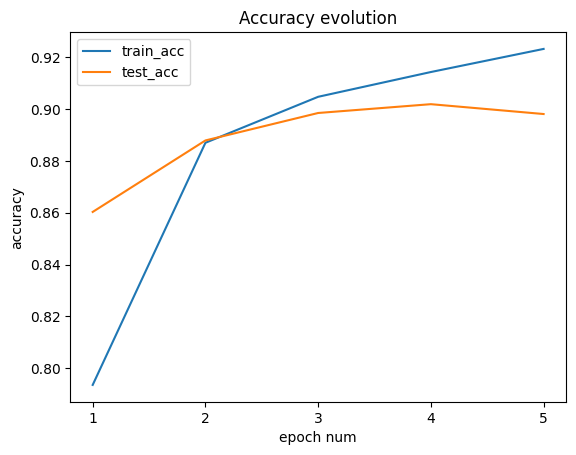

In [33]:
# torch.cuda.empty_cache()
lr, num_epochs = 0.01, 5
trainer = torch.optim.Adam(model.parameters(), lr=lr)
train(model, train_iter, test_iter, trainer, num_epochs, device)

# import os
# duration = 0.25  # seconds
# freq = 660  # Hz
# os.system('play -nq -t alsa synth {} sine {}'.format(duration, freq))

from IPython.display import Audio
sound_file = '/home/max/SOUNDS/service-bell_daniel_simion.mp3'
Audio(sound_file, autoplay=True)

In [25]:
torch.cuda.empty_cache()